In [ ]:
push!(LOAD_PATH, ".")

In [269]:
using Revise

In [271]:
using FileIO, Images, DSP, WavEdit

In [272]:
import vinyl
reload("vinyl")

In [305]:
trackA = WavData("audio/combined_track_A.wav")
trackB = WavData("audio/combined_track_B.wav")

WavEdit.WavData{Float64}([-5.62667e-11 -3.44788e-11; -1.24599e-10 -1.20061e-10; … ; 3.38082e-10 3.30298e-11; 5.55406e-11 -1.2281e-11], 44100.0f0, 0x0020, Dict{Symbol,Any}(Pair{Symbol,Any}(:fmt, WAV.WAVFormat(0xfffe, 0x0002, 0x0000ac44, 0x00056220, 0x0008, 0x0020, WAV.WAVFormatExtension(0x0020, 0x00000000, UInt8[0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x10, 0x00, 0x80, 0x00, 0x00, 0xaa, 0x00, 0x38, 0x9b, 0x71])))))

In [306]:
duration = WavEdit.duration(trackA)
@assert isapprox(WavEdit.duration(trackB), duration, rtol=1e-2)

In [307]:
trackA_samples = filt(digitalfilter(
        Lowpass(2000; fs=trackA.Fs),
        FIRWindow(hanning(64))), trackA.samples[:, 1]);
trackB_samples = filt(digitalfilter(
        Lowpass(2000; fs=trackA.Fs),
        FIRWindow(hanning(64))), trackB.samples[:, 1]);

In [315]:
maximum(trackA_samples)

2.926961687179051

In [335]:
rpm = 33
width = 4500
config = vinyl.Config(groove_fraction=0.4, 
    padding=round(Int, width / 10),
    scaling=0.99 / maximum(trackA_samples))

vinyl.Config
  groove_spacing: Int64 15
  padding: Int64 450
  scaling: Float64 0.33823469720717214
  groove_fraction: Float64 0.4


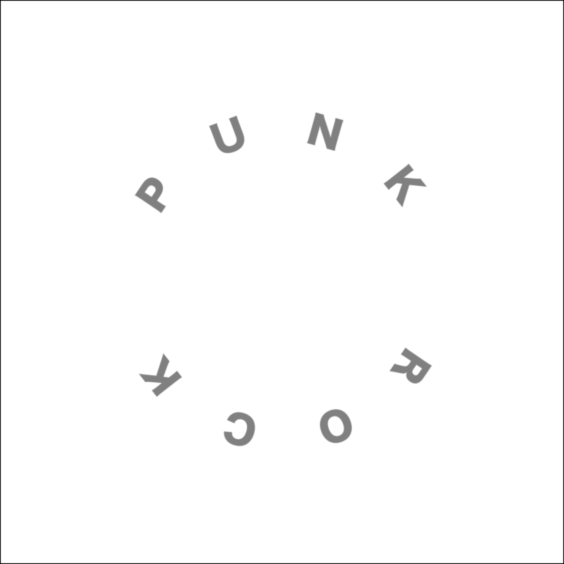

In [397]:
punkrock = Gray.(load("punkrock_56.png"))
# imfilter!(punkrock, punkrock, Kernel.gaussian(3))
punkrock = imresize(punkrock, width, width)
punkrock .= 1 .- (1 .- punkrock) .* 0.5

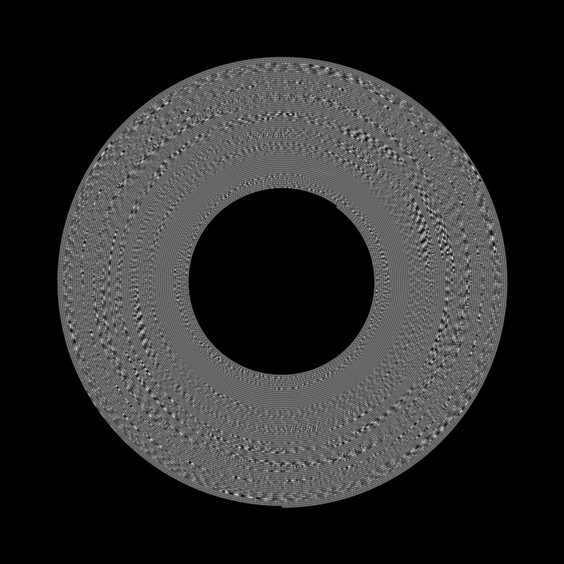

In [398]:
im1_clean = vinyl.cut_record(trackA_samples, trackA.Fs, rpm, width, config)
im2_clean = vinyl.cut_record(reverse(trackB_samples), trackB.Fs, rpm, width, config)

im1 = punkrock .* im1_clean .+ (1 .- punkrock) .* im2_clean
im2 = punkrock .* im2_clean .+ (1 .- punkrock) .* im1_clean
save("spool1.png", im1)
save("spool2.png", im2)
im1

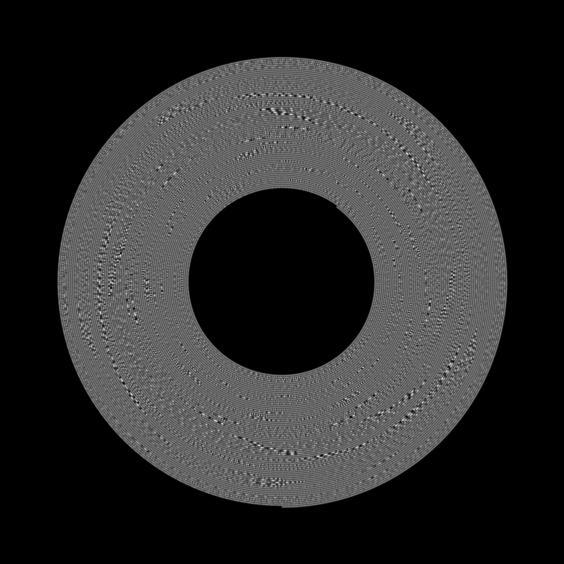

In [399]:
im2

Perhaps your data had out-of-range values?
Try `map(clamp01nan, img)` to clamp values to a valid range.


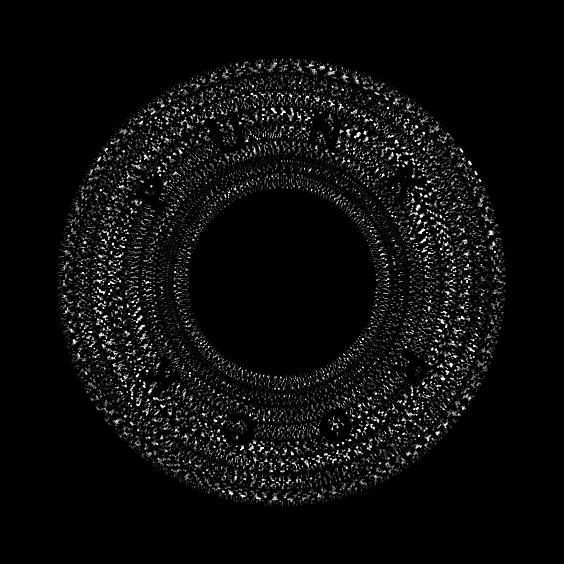

In [400]:
save("difference.png", (im2 .- im1) .* 1)
(im2 .- im1) .* 4

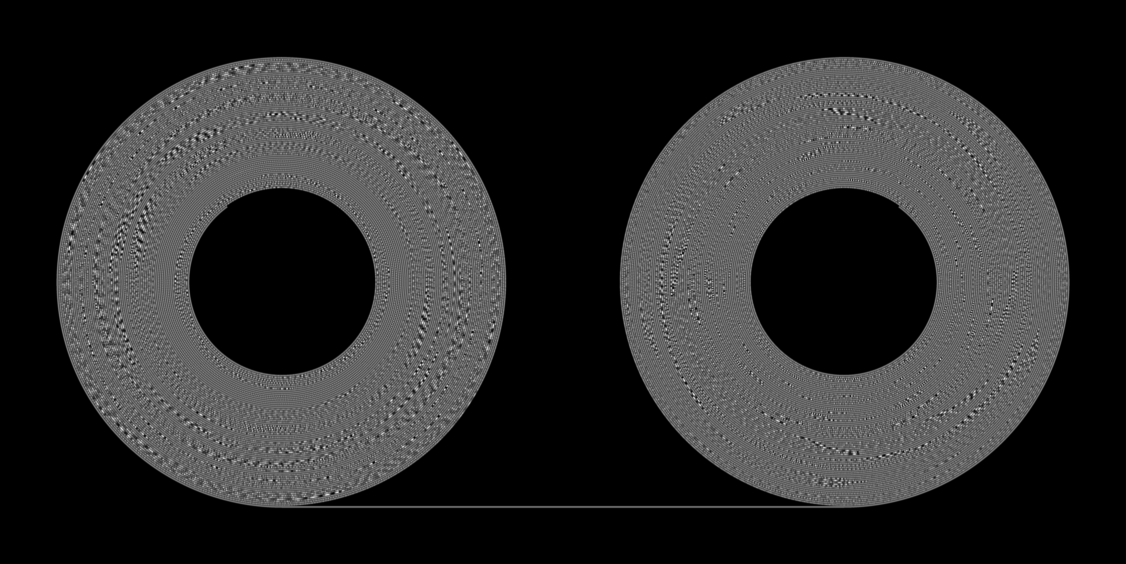

In [401]:
combined = hcat(im1[:, end:-1:1], im2)
g = config.groove_spacing
r = round(Int, 2 * config.groove_fraction * g/2)
combined[(end - config.padding - r):(end - config.padding + r), round(Int, width/2):(end-round(Int, width/2))] = 0.5
save("combined.png", combined)
combined

In [402]:
Fs_play = 8000
wavwrite(vinyl.play_record(im1, Fs_play, rpm, config, duration/1u"s"), "recovered_1.wav", Fs=Fs_play)
wavwrite(reverse(vinyl.play_record(im2, Fs_play, rpm, config, duration/1u"s")), "recovered_2.wav", Fs=Fs_play)